In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pandas.plotting         import scatter_matrix
from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import make_scorer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing   import StandardScaler
from sklearn.svm             import SVR
from sklearn.tree            import DecisionTreeRegressor as Tree

# 2. Bike Sharing: Predicción de Demanda Horaria

En esta sección simularemos nuestra participación en el desafío Bike Sharing  Demand de Kaggle. El objetivo es predecir la demanda de bicicletas sobre la red Capital  Bikeshare de la ciudad de Washington, D.C., en función de la hora del día y otras variables descritas en la tabla 1. En principio, y como muestra la figura, la función es altamente no lineal y no determinista como función de la hora del día. Su objetivo será  entrenar  un  modelo  para  obtener  un  puntaje  correspondiente  al  top-100  del  $“leaderboard”$  final,  es decir superior o igual a $0.37748$. La función utilizada para evaluar este concurso Kaggle se proporciona en la siguiente ecuación:

$$ E_{bikes}\left(y,\hat{y}\right) = \frac{1}{n} \sum_{i} \left( \ln\left(y_i+ 1\right)- \ln\left(\hat{y}+1\right)\right)^{2}$$

donde $y$,$\hat{y} \in \!R^n$ denotan los vectores de observaciones y predicciones respectivamente.

## a)  Cargue los datos de entrenamiento y pruebas como dataframes de pandas . Describa las variables involucradas en el problema, explorando el tipo de datos de que se trata, el número de valores distintos y, si corresponde, un gráfico (e.g. un histograma) que resuma su comportamiento. Su primera operación de pre-procesamiento de datos será obtener la hora del día desde el campo fecha (que en este momento es de tipo string), creando una nueva columna denominada hour y de tipo int . Para hacer esta operación se concatenarán los dataframes de entrenamiento y pruebas y luego se volverán a separar manteniendo la separación original.

In [2]:
dftrain = pd.read_csv('data/bike-sharing/bike_sharing_train.csv')
dfval = pd.read_csv('data/bike-sharing/bike_sharing_val.csv')
dftest = pd.read_csv('data/bike-sharing/bike_sharing_test.csv')
shift_train = len(dftrain)
shift_val = shift_train +  len(dfval)
df = pd.concat([dftrain, dfval, dftest])

In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10886 entries, 0 to 2146
Data columns (total 13 columns):
Unnamed: 0    10886 non-null int64
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(9), object(1)
memory usage: 1.2+ MB


,Unnamed: 0,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,5442.500000,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,3142.661849,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2721.250000,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,5442.500000,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,8163.750000,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,10885.000000,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [4]:
df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['hour'] = pd.to_numeric(df['hour'])

In [5]:
df['day_number'] = pd.to_datetime(df['datetime']).dt.dayofweek
df['day_number'] = pd.to_numeric(df['day_number'])

In [6]:
df['week_number'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%W'))
df['week_number'] = pd.to_numeric(df['week_number'])

In [87]:
df['year'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%Y'))
df['year'] = pd.to_numeric(df['year'])

In [89]:
x_columns = ['season', 'holiday', 'workingday', 'weather','temp', 'atemp', 'humidity', 
             'windspeed', 'hour', 'day_number', 'week_number', 'year']
y_columns = ['casual', 'registered', 'count']
df[x_columns].head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day_number,week_number,year
0,1,0,0,1,9.84,14.395,75,0.0000,3,5,0,2011
1,1,0,0,1,9.84,14.395,75,0.0000,4,5,0,2011
2,1,0,0,2,9.84,12.880,75,6.0032,5,5,0,2011
3,1,0,0,1,9.02,13.635,80,0.0000,6,5,0,2011
4,1,0,0,1,8.20,12.880,86,0.0000,7,5,0,2011


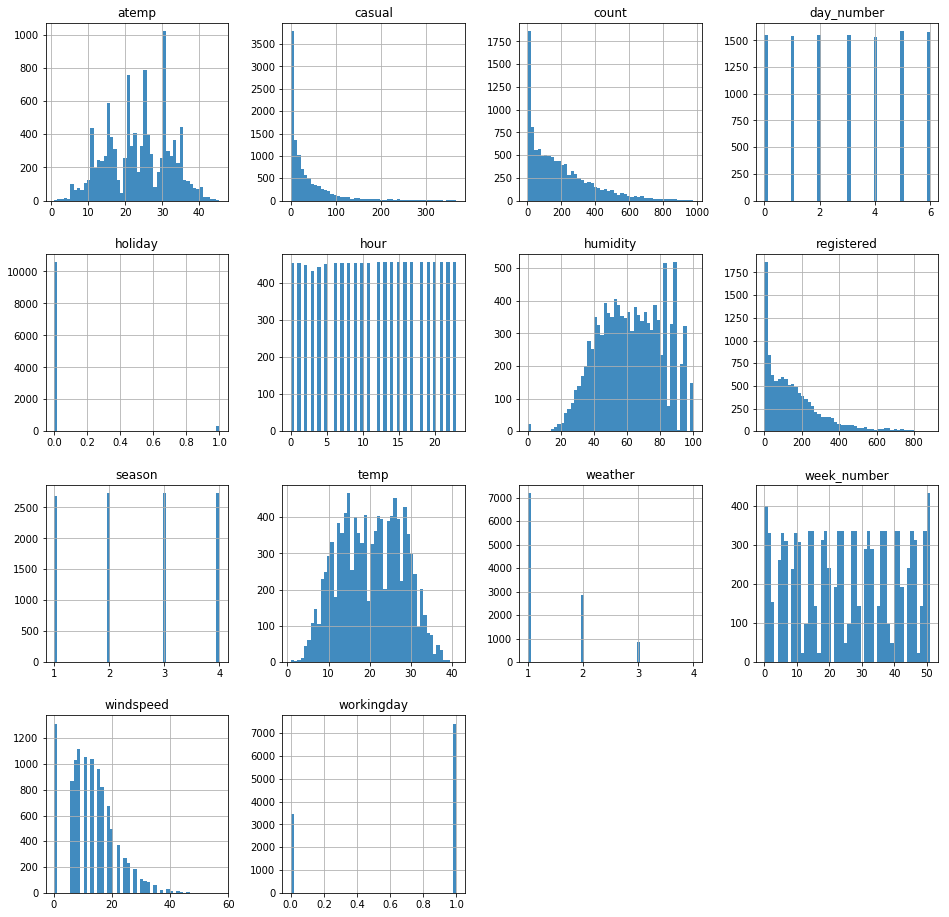

In [66]:
df[x_columns+y_columns].hist(alpha=0.85, bins=50, figsize=(16, 16))
plt.show()

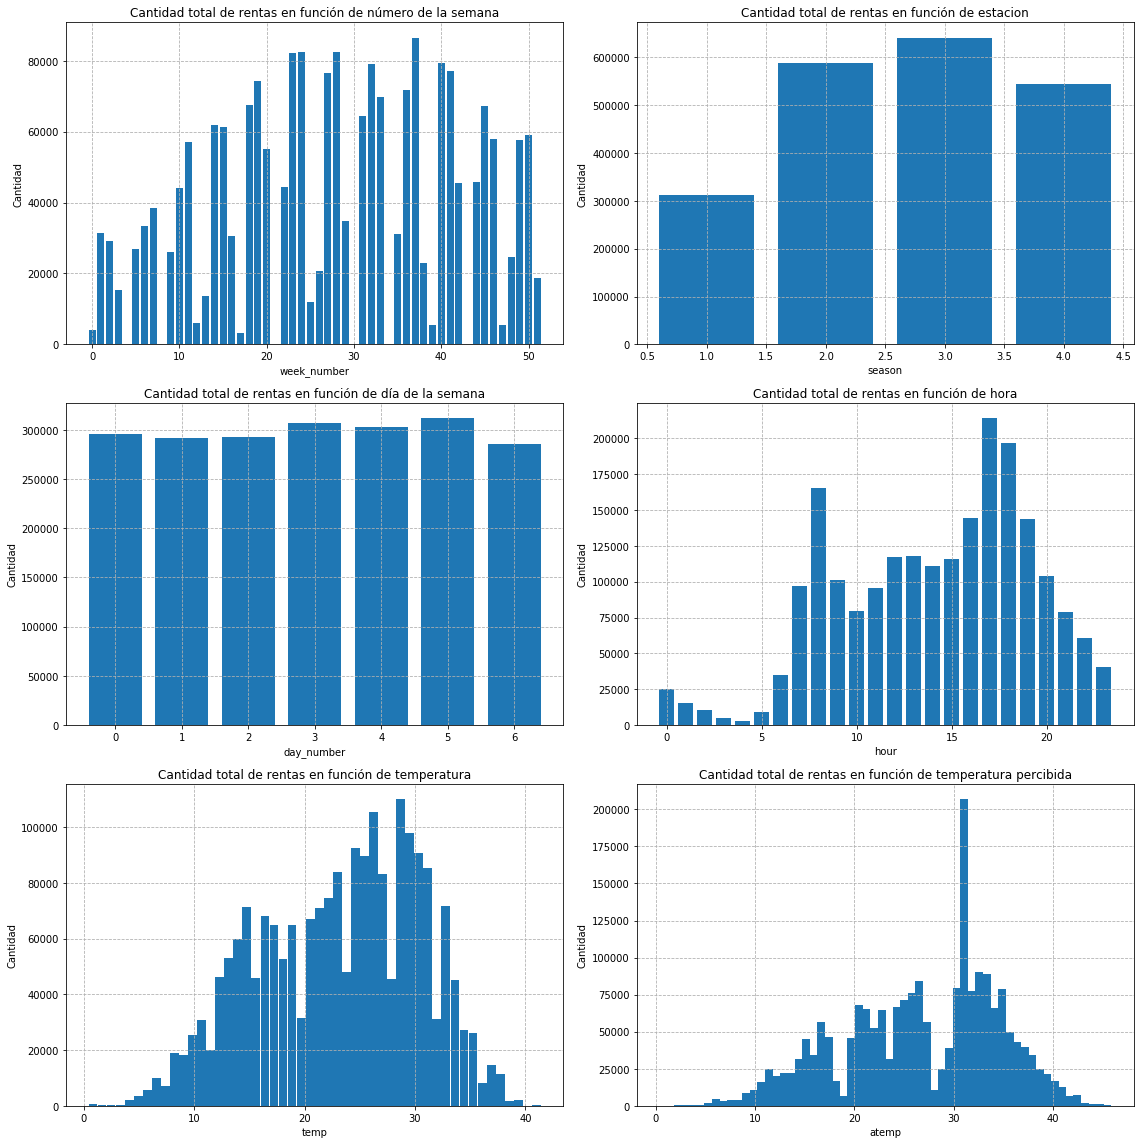

In [11]:
f, axarr = plt.subplots(3, 2, figsize=(16, 16))

columns_name = ['week_number', 'season', 'day_number', 'hour', 'temp', 'atemp']
columns_range = [range(52), range(1,5), range(7), range(24), list(set(df['temp'])),  list(set(df['atemp']))]
columns_title = ['número de la semana', 'estacion', 'día de la semana', 'hora', 'temperatura', 'temperatura percibida']

for i in range(2):
    for j in range(3):
        axarr[j, i].grid(True, linestyle='dashed')
        axarr[j, i].set_title('Cantidad total de rentas en función de '+columns_title[2*j+i])
        axarr[j, i].set_ylabel('Cantidad')
        axarr[j, i].set_xlabel(columns_name[2*j+i])
        a=[df[df[columns_name[2*j+i]]==k]['count'].sum() for k in columns_range[2*j+i]]
        axarr[j, i].bar(columns_range[2*j+i], a)
plt.tight_layout()
plt.show()

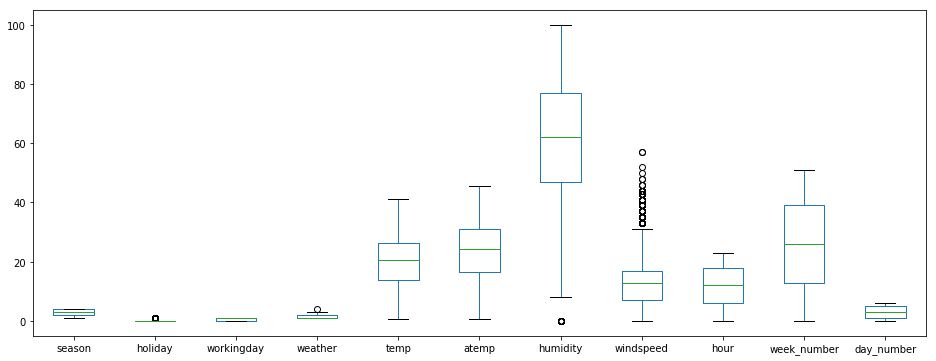

In [12]:
df[x_columns].plot.box(figsize=(16, 6))
plt.show()

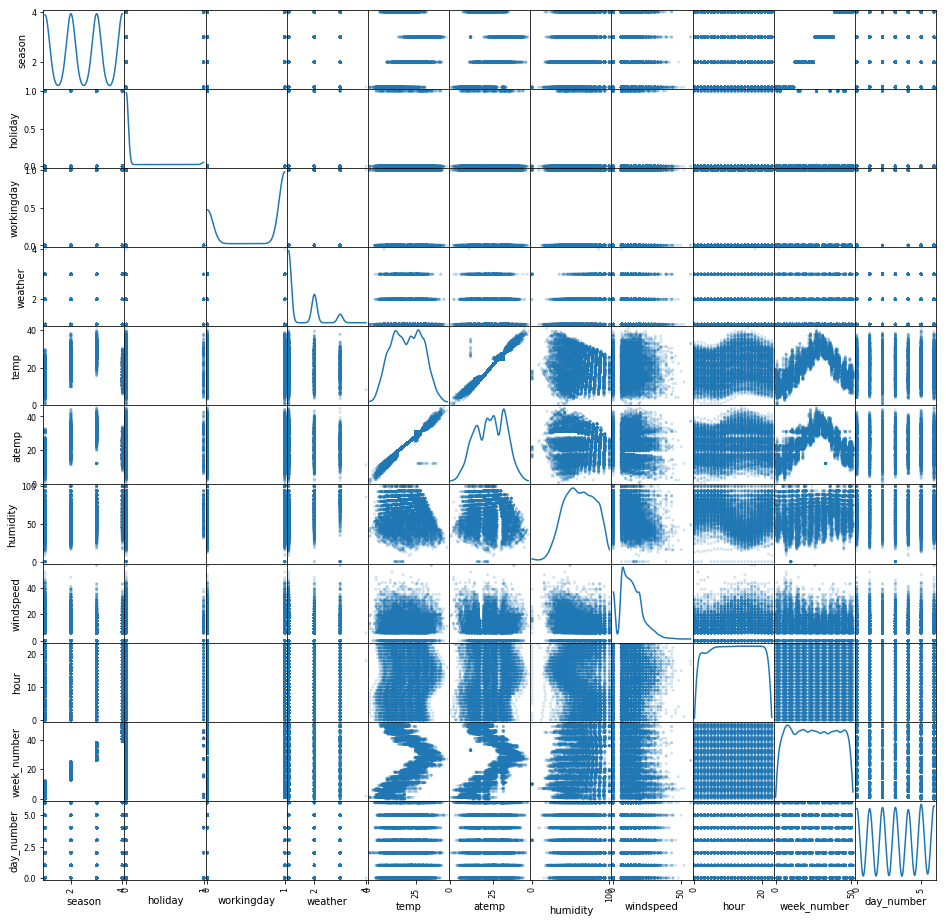

In [13]:
scatter_matrix(df[x_columns], alpha=0.2, figsize=(16, 16), diagonal='kde')
plt.show()

## b)  Entrene  un  árbol  de  regresión  para  resolver  el  problema  usando  parámetros  por  defecto.  
Con  este fin, construya una matriz $X_{train}$ de forma $n_{train} \times d_1$ que contenga los datos de entrenamiento en sus filas, seleccionando las columnas que desee/pueda utilizar para el entrenamiento. 

Evalúe el árbol de regresión ajustado  a  los  datos  de  entrenamiento  sobre  el  conjunto  de  entrenamiento  y  pruebas. 

Construya  un gráfico que compare las predicciones con los valores reales. 

En este punto usted debiese tener un modelo con puntaje del orden de $0.59$, lo que lo dejará más o menos en la posición 2140 de la competencia.

In [168]:
def kagg_loss_func(y_true, y_pred):
    diff = np.log(y_pred + 1.0) - np.log(y_true + 1.0)
    return np.sqrt(np.sum(np.square(diff)) / len(y_pred))

def kagg_log_loss_func(y_true, y_pred):
    diff = np.log(np.exp(y_pred) + 1.0) - np.log(y_true + 1.0)
    return np.sqrt(np.sum(np.square(diff)) / len(y_pred))

def kagg_sqrt_loss_func(y_true, y_pred):
    diff = np.log(y_pred**2 + 1.0) - np.log(y_true + 1.0)
    return np.sqrt(np.sum(np.square(diff)) / len(y_pred))
 
loss = make_scorer(kagg_loss_func, greater_is_better=False)
loss_log = make_scorer(kagg_log_loss_func, greater_is_better=False)
loss_sqrt = make_scorer(kagg_sqrt_loss_func, greater_is_better=False)

In [170]:
def eval_model(model, scoring, x_train, y_train, x_test, y_test, x_val=None, y_val=None, plot=True):
    kagg_train = -scoring(model, x_train, y_train)
    print("KAGG train = %f" % kagg_train)
    if (not x_val is None) and (not y_val is None):
        kagg_val = -scoring(model, x_val, y_val)
        print("KAGG val = %f" % kagg_val)
    y_pred_test = model.predict(x_test)
    kagg_test = -scoring(model, x_test, y_test)
    print("KAGG test = %f" % kagg_test)
    if plot:
        plt.figure(figsize=(14,14))
        plt.plot(y_test, y_pred_test, '.')
        plt.plot(range(900), range(900), '--')
        plt.show()

In [41]:
def split_dataset(df, x_columns, shift_train, shift_val, val=True):
    Xdf = df.loc[:, x_columns]
    Ydf = df.loc[:, 'count']
    out = []
    if val:
        out.append(Xdf[0:shift_train].values)
        out.append(Ydf[0:shift_train].values)
        out.append(Xdf[shift_train:shift_val].values)
        out.append(Ydf[shift_train:shift_val].values)
    else:
        out.append(Xdf[0:shift_val].values)
        out.append(Ydf[0:shift_val].values)
    out.append(Xdf[shift_val:].values)
    out.append(Ydf[shift_val:].values)
    return tuple(out)

In [192]:
def plot_grid_out(out, c, l, x_space, xscale='linear', xlabel=''):
    pl = ['train', 'test']
    pl2 = ['train', 'val']
    f, axarr = plt.subplots(1, 2, figsize=(17,5))
    base = len(c)
    count = int(len(out['mean_test_score'])/base)
    for k in range(2):
        axarr[k].set_xscale(xscale)
        axarr[k].set_xlabel(xlabel)
        axarr[k].set_ylabel('loss')
        for i in range(base):
            m = -np.array([out['mean_'+pl[k]+'_score'][i+base*j] for j in range(count)])
            s = -2*np.array([out['std_'+pl[k]+'_score'][i+base*j] for j in range(count)])
            axarr[k].grid(True, linestyle='dashed')
            axarr[k].fill_between(x_space, m - s, m + s, alpha=0.25, color=c[i])
            axarr[k].plot(x_space, m, marker='o', linestyle='--', color=c[i], label=pl2[k]+' score '+l[i])
            axarr[k].legend(loc='lower right')
    plt.show()

In [165]:
x_columns = ['season', 'holiday', 'workingday', 'weather','temp', 'atemp', 'humidity', 'windspeed', 'hour']
x_train, y_train, x_val, y_val, x_test, y_test = split_dataset(df, x_columns, shift_train, shift_val)

In [166]:
model = Tree(random_state=0)
model.fit(x_train, y_train)
score_test = 100*model.score(x_test, y_test)
print('SCORE TEST = %.2f%%' % score_test)

SCORE TEST = 70.34%


KAGG train = 0.028516
KAGG val = 0.554511
KAGG test = 0.574239


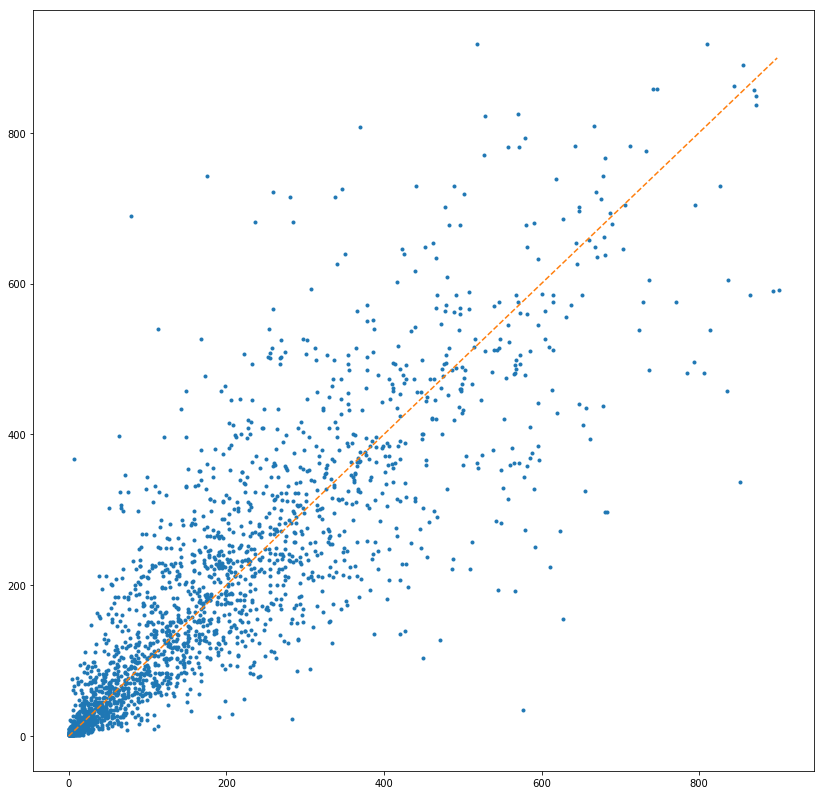

In [171]:
eval_model(model, loss, x_train, y_train, x_test, y_test, x_val, y_val)

## c)  Mejore el árbol de regresión definido en el punto anterior haciendo modificaciones a los hiper-parámetros del modelo. 

In [196]:
x_train, y_train, x_test, y_test = split_dataset(df, x_columns, shift_train, shift_val, False)

In [185]:
tuned_parameters = [{
    'criterion': ['mse', 'friedman_mse', 'mae'],
    'max_depth': [i for i in range(2, 25)]
}]

clf = GridSearchCV(Tree(), tuned_parameters, scoring=loss, cv=5, verbose=1, return_train_score=True)
clf.fit(x_train, y_train)
clf.best_params_

Fitting 5 folds for each of 69 candidates, totalling 345 fits


[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:  9.3min finished


{'criterion': 'friedman_mse', 'max_depth': 10}

In [187]:
-clf.best_score_

0.4425514750830748

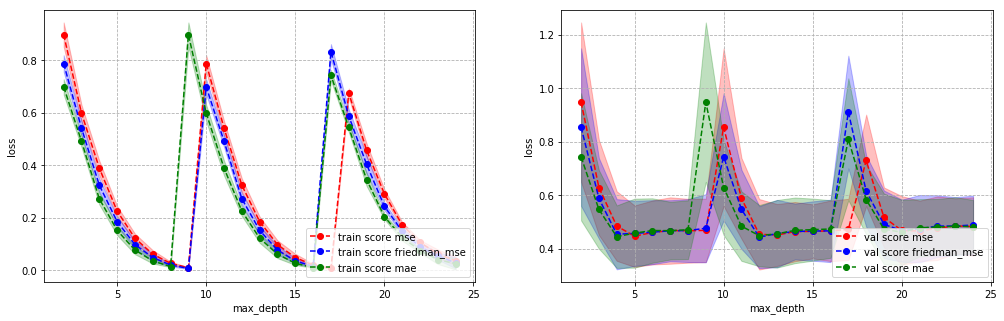

In [193]:
color = ['r', 'b', 'g']
l = ['mse', 'friedman_mse', 'mae']
xspace = range(2, 25)

plot_grid_out(clf.cv_results_ , color, l, xspace, xlabel='max_depth')

KAGG train = 0.282342
KAGG test = 0.417738


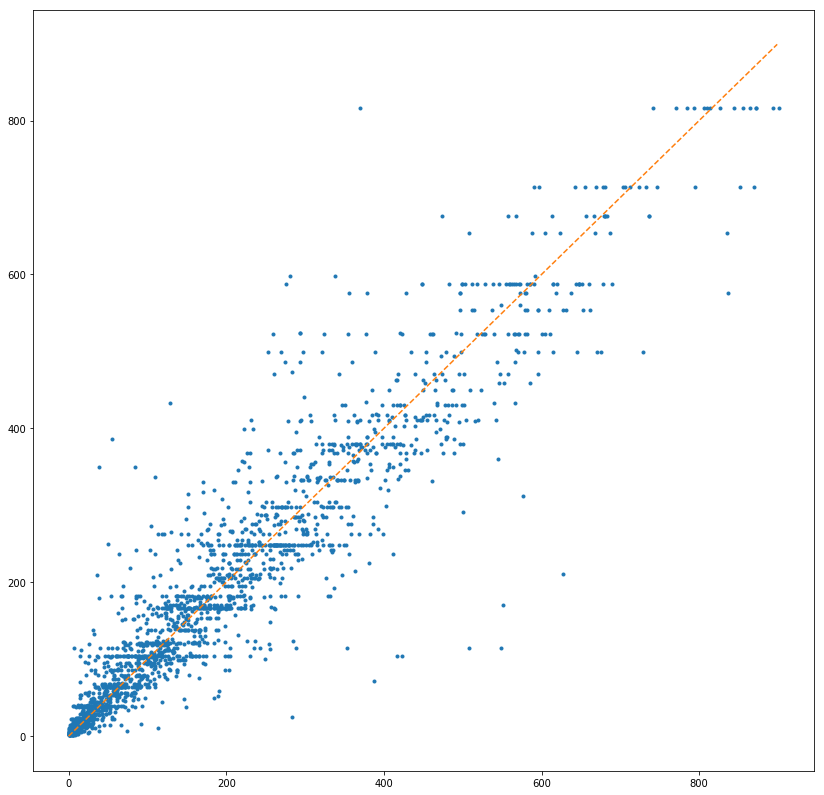

In [199]:
model = clf.best_estimator_
model.fit(x_train, y_train)
eval_model(model, loss, x_train, y_train, x_test, y_test)

## d)  Mejore el árbol de regresión definido en el punto anterior haciendo modificaciones sobre la representación utilizada para aprender desde los datos. 

### 1) Add date info

In [173]:
x_columns = ['season', 'holiday', 'workingday', 'weather','temp', 'atemp', 'humidity', 
             'windspeed', 'hour', 'day_number', 'week_number', 'year']
x_train, y_train, x_test, y_test = split_dataset(df, x_columns, shift_train, shift_val, False)

In [91]:
tuned_parameters = [{
    'criterion': ['mse', 'friedman_mse', 'mae'],
    'max_depth': [i for i in range(2, 25)]
}]

clf = GridSearchCV(Tree(), tuned_parameters, scoring=loss, cv=5, verbose=1, return_train_score=True)
clf.fit(x_train, y_train)
clf.best_params_

Fitting 5 folds for each of 69 candidates, totalling 345 fits


[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed: 10.9min finished


{'criterion': 'friedman_mse', 'max_depth': 12}

In [92]:
clf.best_score_

0.85668892994449986

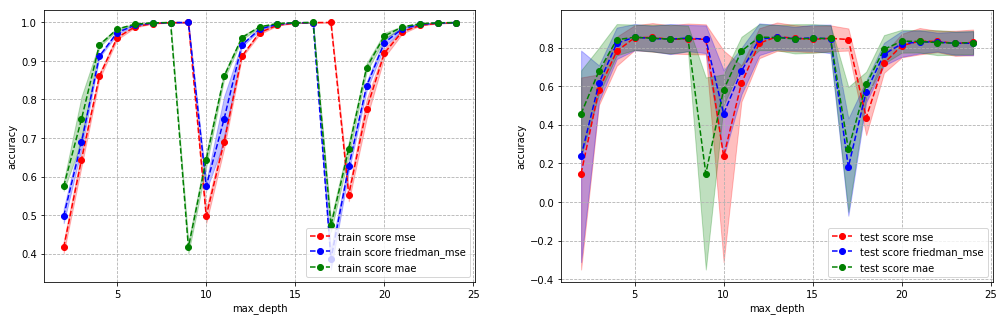

In [93]:
plot_grid_out(clf.cv_results_ , color, l, xspace, xlabel='max_depth')

KAGG train=0.198517
KAGG test=0.415551


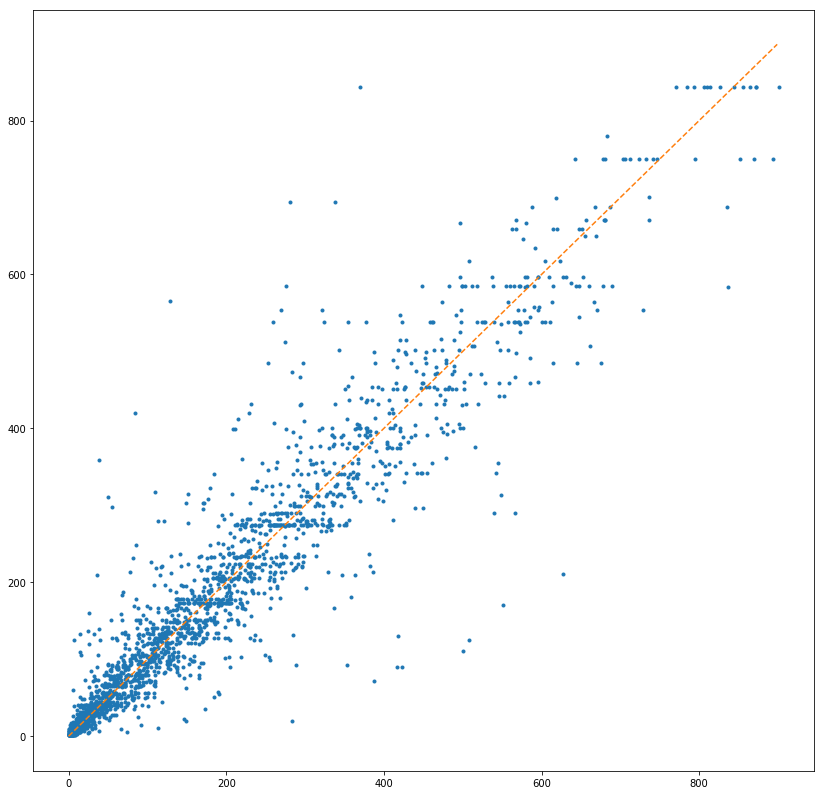

In [95]:
model = Tree(random_state=0, criterion='friedman_mse', max_depth=10)
model.fit(x_train, y_train)
eval_model(model, loss, x_train, y_train, x_test, y_test)

eval_model(clf.best_estimator_, loss, x_train, y_train, x_test, y_test)

### 2) center data

In [96]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_train)

In [98]:
tuned_parameters = [{
    'criterion': ['mse', 'friedman_mse', 'mae'],
    'max_depth': [i for i in range(2, 25)]
}]

clf = GridSearchCV(Tree(), scoring=loss, tuned_parameters, cv=5, verbose=1, return_train_score=True)
clf.fit(x_train_scaled, y_train)
clf.best_params_

Fitting 5 folds for each of 69 candidates, totalling 345 fits


[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed: 11.4min finished


{'criterion': 'friedman_mse', 'max_depth': 12}

In [99]:
clf.best_score_

0.8574458286761597

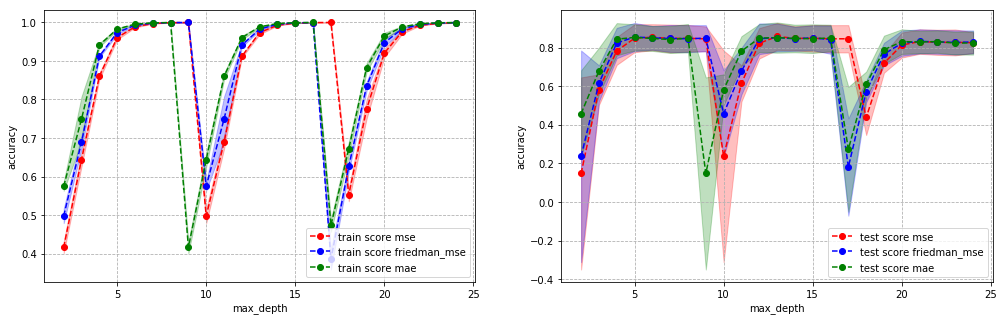

In [100]:
plot_grid_out(clf.cv_results_ , color, l, xspace, xlabel='max_depth')

KAGG train=1.582867
KAGG test=1.574281


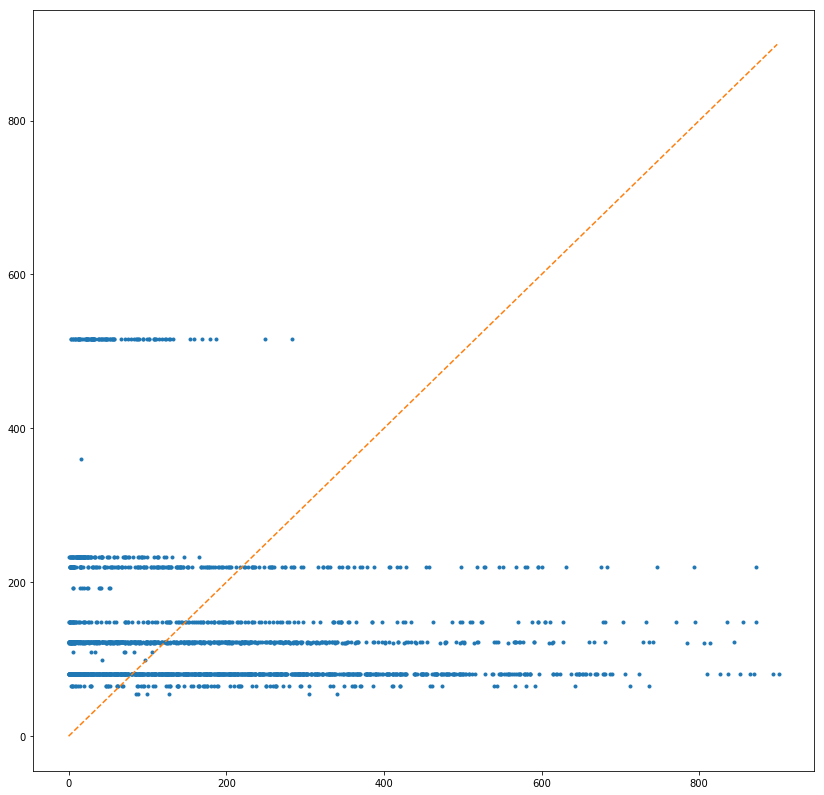

In [101]:
eval_model(clf.best_estimator_, loss, x_train, y_train, x_test, y_test)

### 3) sqrt to count

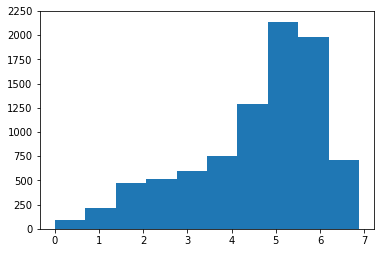

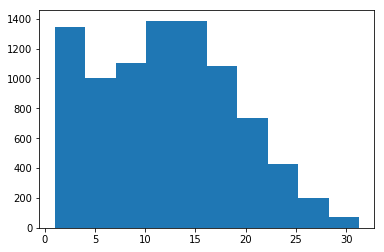

In [107]:
plt.hist(np.log())
plt.show()

In [109]:
y_train_sqrt = np.sqrt(y_train)
y_test_sqrt = np.sqrt(y_test)

In [110]:
tuned_parameters = [{
    'criterion': ['mse', 'friedman_mse', 'mae'],
    'max_depth': [i for i in range(2, 25)]
}]

clf = GridSearchCV(Tree(), scoring=loss_sqrt, tuned_parameters, cv=5, verbose=1, return_train_score=True)
clf.fit(x_train, y_train_sqrt)
clf.best_params_

Fitting 5 folds for each of 69 candidates, totalling 345 fits


[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed: 10.0min finished


{'criterion': 'friedman_mse', 'max_depth': 13}

In [111]:
clf.best_score_

0.88694669611332355

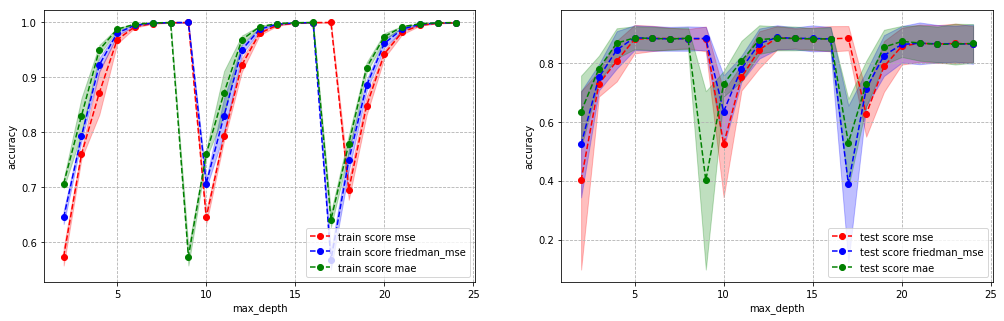

In [112]:
plot_grid_out(clf.cv_results_ , color, l, xspace, xlabel='max_depth')

In [116]:
eval_model(clf.best_estimator_, loss_sqrt, x_train, y_train, x_test, y_test, plot=False)

KAGG train=0.158517
KAGG test=0.429501


In [174]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [130]:
tuned_parameters = [{
    'criterion': ['mse', 'friedman_mse', 'mae'],
    'max_depth': [i for i in range(2, 25)]
}]

clf = GridSearchCV(Tree(), tuned_parameters, scoring=loss_log, cv=5, verbose=1, return_train_score=True)
clf.fit(x_train, y_train_log)
clf.best_params_

Fitting 5 folds for each of 69 candidates, totalling 345 fits


[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed: 12.0min finished


{'criterion': 'friedman_mse', 'max_depth': 11}

In [181]:
clf.best_score_

0.88380022628518717

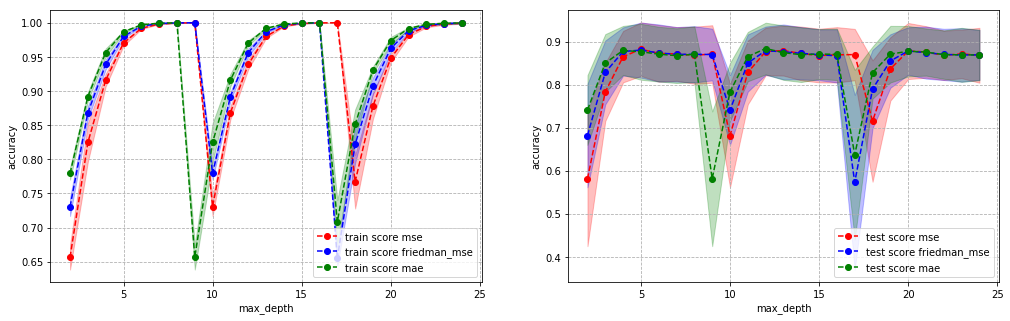

In [176]:
plot_grid_out(clf.cv_results_ , color, l, xspace, xlabel='max_depth')

In [184]:
eval_model(clf.best_estimator_, loss_log, x_train, y_train, x_test, y_test, plot=False)

KAGG train = 0.240101
KAGG test = 0.428041


## e)  Entrene una SVM no lineal para resolver el problema midiendo el efecto de las distintas representaciones que haya descubierto hasta este punto. 

Un detalle importante es que antes de entrenar la SVM sería aconsejable  hacer  dos  tipos  de  pre-procesamiento  adicional  de  los  datos:  
- (i)  codificar  las  variables categóricas  en  un  modo  apropiado  -  por  ejemplo  como  vector  binario  con  un  1  en  la  posición  del valor adoptado-,
- (ii) escalar los atributos de modo que queden centrados y con rangos comparables.

Usando parámetros por defecto para la SVM debiese obtener un score del orden de 0.344, quedando definitivamente en el top-10 de la competencia.

In [28]:
#load dataframes as before ...
df = pd.concat([dftrain,dfval,dftest])
df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['cday'] = pd.to_datetime(df['datetime']).dt.dayofweek
df['hour'] = pd.to_numeric(df['hour'])
df['cday'] = pd.to_numeric(df['cday'])
Xdf=df.loc[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','cday']]

#PASO IMPORTANTE MAS ABAJO ...
Xdf = pd.get_dummies(Xdf,columns=['season', 'weather','hour','cday'])
Ydf=df.loc[:,'count']

C:\Users\tres1\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


In [29]:
scalerX = StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_val = scalerX.fit_transform(X_val)
X_test = scalerX.transform(X_test)

In [33]:
model = SVR()
model.fit(X_train,Y_train)
Y_pred_train = model.predict(X_train)
Y_pred_val =  model.predict(X_val)
Y_pred_test = model.predict(X_test)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
kagg_test = eval_bikemodel(Y_pred_test,Y_test)
print("KAGG TEST=%f"%kagg_train)
print("KAGG TEST=%f"%kagg_val)
print("KAGG TEST=%f"%kagg_test)

KAGG TEST=nan
KAGG TEST=nan
KAGG TEST=nan


C:\Users\tres1\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


## f)  Mejore  la  SVM  definida  en  el  punto  anterior  haciendo  modificaciones  a  los  hiper-parámetros  de  la máquina (C, $\epsilon$ o la misma función de kernel). 

Naturalmente, está absolutamente prohibido tomar este tipo de decisiones de diseño mirando el resultado de pruebas. Debe realizar estas elecciones evaluando  sobre  el  conjunto  de  validación.  Si  no  desea  utilizarlo,  y  prefiere  implementar  validación  cruzada u  otra  técnica  automática,  tiene  la  ventaja  de  poder  usar  el  conjunto  de  validación  como  parte  del entrenamiento.

In [34]:
model = SVR(C=1,epsilon=0.01)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
kagg_test = eval_bikemodel(Y_pred_test,Y_test)
print("KAGG TEST=%f"%kagg_train)
print("KAGG TEST=%f"%kagg_val)
print("KAGG TEST=%f"%kagg_test)

KAGG TEST=nan
KAGG TEST=nan
KAGG TEST=nan


C:\Users\tres1\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


## g)  Evalúe el efecto de utilizar el dataset de validación para entrenamiento y seleccionar los parámetros estructurales del árbol de clasificación y la SVM usando validación cruzada. El código de ejemplo para esto ha sido proporcionado en las tareas 1 y 2, pero se adjunta de nuevo a continuación

In [ ]:
kf = KFold(n_splits=10)

mse_cv = 0
for train, val in kf.split(Xm):
    model = #define your model
    model.fit(Xm[train], ym[train])
    yhat_val = model.predict(Xm[val])
    ytrue_val = ym[val]
    score_fold = eval_bikemodel(yhat_val,ytrue_val)
    mse_cv += score_fold
mse_cv = mse_cv / 10

## h)  Evalúe  el  efecto  de  utilizar  un  ensamblado  de  2  máquinas  de  aprendizaje  para  predecir  la  demanda total de bicicletas. Un modelo se especializará en la predicción de la demanda de bicicletas de parte de usuarios registrados y otra en la predicción de la demanda de usuarios casuales. Hay razones claras para pensar que los patrones son distintos.

In [35]:
Ydf=df.ix[:,'count'] #demanda total
Ydf=df.ix[:,'registered'] #demanda registrada
Ydf=df.ix[:,'casual'] #demanda casual

## i)  Evalúe el efecto de utilizar un algoritmo genérico para ensamblar máquinas de aprendizaje para predecir la demanda total de bicicletas. Puede experimentar con una sola técnica (e.g.Random Forest), discutasla evolución a medida que aumenta el número de máquinas.

In [37]:
max_depth=20
model = RandomForestRegressor(n_estimators=10,max_depth=max_depth,random_state=0)